In [120]:
# installations:
# pip install torch
# pip install torchbnn

# REMEMBER: GPU is actually slower in BNN training (unless using Pyro-module or something else)

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

In [121]:
df = pd.read_csv("bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [122]:
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})


In [123]:
from sklearn.preprocessing import LabelEncoder

# Список категориальных колонок
categorical_cols = ['job', 'marital', 'education', 'default', 
                    'housing', 'loan', 'contact', 'month', 
                    'poutcome', 'deposit']

# Создаем LabelEncoder для каждой колонки
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # сохранить если потом нужно обратно расшифровать

In [126]:

# Показать типы колонок
print("📌 Типы данных:")
print(df.dtypes)

# Уникальные значения для каждой колонки
print("\n🔍 Количество уникальных значений:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


📌 Типы данных:
age          int64
job          int32
marital      int32
education    int32
default      int32
balance      int64
housing      int32
loan         int32
contact      int32
day          int64
month        int32
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int32
deposit      int64
dtype: object

🔍 Количество уникальных значений:
age: 76 unique values
job: 12 unique values
marital: 3 unique values
education: 4 unique values
default: 2 unique values
balance: 3805 unique values
housing: 2 unique values
loan: 2 unique values
contact: 3 unique values
day: 31 unique values
month: 12 unique values
duration: 1428 unique values
campaign: 36 unique values
pdays: 472 unique values
previous: 34 unique values
poutcome: 4 unique values
deposit: 2 unique values


In [125]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [127]:
target_variable = "deposit"
df = df.dropna()
df = df.drop_duplicates()

df = df.sample(4000) 


In [128]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
7672,49,1,1,0,0,239,0,0,0,22,1,90,3,-1,0,3,0
1329,23,4,2,2,0,1506,0,0,0,9,7,131,4,-1,0,3,1
5961,37,4,1,2,0,620,1,0,0,17,9,93,3,-1,0,3,0
2965,38,4,1,3,0,3576,0,0,0,25,9,349,2,183,1,2,1
4154,27,1,2,1,0,294,1,1,2,28,8,694,2,-1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,28,8,2,2,0,22,1,0,0,15,8,536,2,-1,0,3,1
2394,31,4,2,1,0,202,1,0,0,8,5,167,1,62,1,0,1
10801,28,0,2,2,0,373,1,0,0,4,3,126,1,-1,0,3,0
4325,52,4,1,2,0,40,0,0,0,19,9,1265,3,-1,0,3,1


In [129]:
df[target_variable].value_counts() 

deposit
0    2106
1    1894
Name: count, dtype: int64

In [130]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# get unique values in target variable
categories = list(np.unique(df[target_variable]))

# Split features and target
X = df.drop(columns=[target_variable]).values
y = df[target_variable].values

# let's encode our target from the original, eg. 0, 1, 2, 3, 4, 5
le = LabelEncoder()
y = le.fit_transform(y)

# if bad result, consider shuffling the dataset just in case
# normalize variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train/test, 80% for training, remaining 20% for test/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# split into test and validation (50% in half)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# convert to PyTorch tensor format
X_train, X_test, X_val = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_val, dtype=torch.float32)
y_train, y_test, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long), torch.tensor(y_val, dtype=torch.long) 

# create PyTorch dataloaders, YOU CAN ADJUST THE BATCH SIZES IF YOU WISH
# basic rule: bigger batch size => faster training, but more memory needed
# only shuffle the training dataset, NEVER SHUFFLE TEST/VAL
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)


In [132]:
# all common hyperparameters we can finetune in the future

# sigma = standard deviation of the noise term (this is often optimized)
# if model is too confident and OVERFITS at the same time, INCREASE sigma
# if predictions are too noisy, too much variation or uncertain  => DECREASE sigma
# COMMON VALUES 0.1 - 0.5

# lambda_kl = amount of KL in the loss function => regularization parameter to avoid OVERFITTING
# if model overfits => increase, if model underfits => decrease
# COMMON VALUES 0.0+ - 0.2

# mu = mean of distribution (you can usually use the defaul 0 in classification)
# if model overfits => decrease mu
# if model underfits => increase mu
# mu = 0 => in the middle of standard distribution (range -3 to +3) => this needs be checked!
# COMMON VALUES: usually 0 in classification

# mc_samples_eval = monte carlo sample size used to approximate distributions in weights
# more samples used => more accurate uncertainty estimation (but heavier to compute)
# if uncertainty is not optimal, try increasing mc_sample -size a little bit
# if model training is too heavy or underfits, you can decrease the sample size
# COMMON VALUES: 25 - 200

mu = 0
sigma = 0.4
lambda_kl = 0.1
mc_samples_eval = 50

# remember to adjust the BNN network structure in the below cell if needed
# amount of layers, layer sizes, amount of dropout regularization etc.

# learning rate is same as in ANN => controls the aggressiveness of optimization
# too large value => model overshoots optimization attempts
# too small value => model learns too slowly
# COMMON VALUES similar to ANN learning rates, small values (0.03 or less), usually 0.1 or less
bnn_learning_rate = 0.001

# weight_decay = regularization applied to model weights (probability distributions)
# penalizes large weights IN ORDER to prevent OVERFITTING
# if model overfits => you can try increasing weight decay, if underfits => try decreasing
# COMMON VALUES are usually quite small, 0.0001 to 0.0005
bnn_weight_decay = 0.0001

In [133]:
# Bayesian Neural Network -model (BNN) with deeper layers and Monte-Carlo dropout
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim, mu=0, sigma=0.5):
        super().__init__()
        # DEFINE ALL LAYERS THAT WILL BE COMBINED INTO ONE MODEL IN forward()
        # NOTE: Torch requires as to "chain" connected layer => out_features and in_features have to match in connected layers
        # for example "in_features=96, out_features=48" means that previous layers to have out_features of 96
        # and the next layer has to have in features of 48
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=input_dim, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=128, out_features=64)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=64, out_features=32)
        self.fc4 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=32, out_features=16)
        self.fc5 = bnn.BayesLinear(prior_mu=mu, prior_sigma=sigma, in_features=16, out_features=output_dim)
        self.relu = nn.ReLU()

        # adjust dropout rate to increase regularization
        self.dropout = nn.Dropout(0.3)  

        # THE BATCH NORMALIZATION SIZES HAVE THE MATCH THE OUTPUT OF THE CORRESPONDING LAYER
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.batch_norm4 = nn.BatchNorm1d(16)
    
    # "forward pass", if mc_dropout = True => adds a dropout layer between the BayesLinear -layers
    def forward(self, x, mc_dropout=False):
        # NOTE: batch normalization helps in stabilizing the training process
        x = self.batch_norm1(self.relu(self.fc1(x))) 
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm2(self.relu(self.fc2(x)))
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm3(self.relu(self.fc3(x)))
        x = self.dropout(x) if mc_dropout else x
        x = self.batch_norm4(self.relu(self.fc4(x)))
        x = self.dropout(x) if mc_dropout else x
        return self.fc5(x)

In [134]:
 # model, loss, optimizer
model = BayesianNN(input_dim=X.shape[1], 
                   output_dim=len(np.unique(y)),
                   sigma=sigma,
                   mu=mu
                   )

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss() 

# Bayesian KL Divergence Loss (efficient regularization for BNN)
bkl_loss = bnn.BKLLoss(reduction='mean')  

# AdamW is common in BNN
optimizer = optim.AdamW(model.parameters(), lr=bnn_learning_rate, weight_decay=bnn_weight_decay)

In [135]:
# evaluate function with uncertainty estimation
def evaluate(model, loader, mc_samples=mc_samples_eval):
    # set model to evaluation mode
    model.eval() 
    total_correct = 0
    total_samples = 0
    total_loss = 0
    uncertainties = []

    # disable gradient updates during evaluation
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs_list = [model(X_batch, mc_dropout=True) for _ in range(mc_samples)]
            outputs_stack = torch.stack(outputs_list) 

            # average prediction and standard deviation (uncertainty)
            outputs_mean = outputs_stack.mean(dim=0)  
            outputs_std = outputs_stack.std(dim=0)

            loss = criterion(outputs_mean, y_batch)
            total_loss += loss.item()

            probs = torch.softmax(outputs_mean, dim=1)
            preds = torch.argmax(probs, dim=1)

            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)

            uncertainties.extend(outputs_std.mean(dim=1).cpu().numpy()) 

    # current accuracy, loss and average uncertainty
    accuracy_score = total_correct / total_samples
    nll = total_loss / len(loader) 
    avg_uncertainty = np.mean(uncertainties)  

    print(f"Val Accuracy: {accuracy_score:.4f}, Val loss: {nll:.4f}, Avg. Uncertainty: {avg_uncertainty:.4f}")

    # return per-sample uncertainty if needed
    return accuracy_score, nll, avg_uncertainty, uncertainties  

# training loop with BKLLoss
def train(model, loader, epochs):
    model.train()
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['val_accuracy'] = []
    history['avg_uncertainty'] = []
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch, mc_dropout=True)
            
            # compute cross-entropy and BKL loss and combine them
            ce_loss = criterion(outputs, y_batch)
            kl_loss = bkl_loss(model)
            loss = ce_loss + lambda_kl * kl_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(loader):.4f}")

        val_accuracy, val_loss, avg_uncertainty, _ = evaluate(model, val_loader)
        history['train_loss'].append(total_loss / len(loader))
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['avg_uncertainty'].append(avg_uncertainty)

        # set model to training mode for next epoch
        model.train()
        
    return history

In [136]:
history = train(model, train_loader, epochs=1200) 

Epoch 1/1200, Training Loss: 1.2492
Val Accuracy: 0.5050, Val loss: 0.7003, Avg. Uncertainty: 1.0976
Epoch 2/1200, Training Loss: 1.2191
Val Accuracy: 0.5275, Val loss: 0.6928, Avg. Uncertainty: 1.0605
Epoch 3/1200, Training Loss: 1.1689
Val Accuracy: 0.5375, Val loss: 0.7015, Avg. Uncertainty: 1.0444
Epoch 4/1200, Training Loss: 1.1518
Val Accuracy: 0.5750, Val loss: 0.6915, Avg. Uncertainty: 0.9361
Epoch 5/1200, Training Loss: 1.1291
Val Accuracy: 0.5400, Val loss: 0.6931, Avg. Uncertainty: 0.8980
Epoch 6/1200, Training Loss: 1.0951
Val Accuracy: 0.5350, Val loss: 0.7067, Avg. Uncertainty: 0.9145
Epoch 7/1200, Training Loss: 1.0949
Val Accuracy: 0.5300, Val loss: 0.6998, Avg. Uncertainty: 0.8636
Epoch 8/1200, Training Loss: 1.0440
Val Accuracy: 0.5300, Val loss: 0.6949, Avg. Uncertainty: 0.8384
Epoch 9/1200, Training Loss: 1.0416
Val Accuracy: 0.5025, Val loss: 0.7062, Avg. Uncertainty: 0.7900
Epoch 10/1200, Training Loss: 0.9708
Val Accuracy: 0.5200, Val loss: 0.6953, Avg. Uncertain

In [137]:
# get predictions etc. for test data
model.eval()
y_true = y_test.cpu().numpy()
y_pred = []
y_pred_probs = [] 

with torch.no_grad():
    for X_batch, _ in test_loader:
        # get average outputs, average of 10 predictions for each
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(10)]
        outputs_stack = torch.stack(outputs_list)  
        outputs_mean = outputs_stack.mean(dim=0)  
        preds = torch.argmax(outputs_mean, dim=1)
        probs = torch.softmax(outputs_mean, dim=1)
        y_pred_probs.extend(probs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

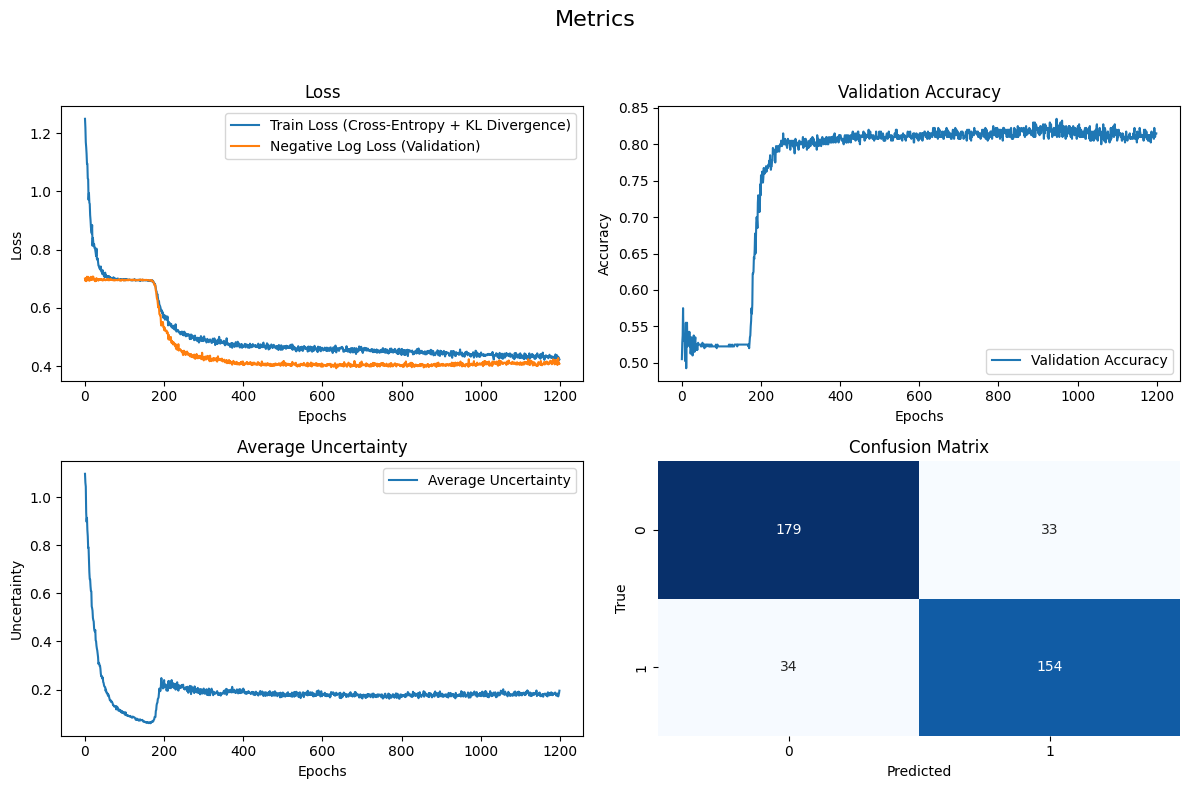

In [138]:
# plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Metrics', fontsize=16)

# BNN, losses
axes[0, 0].plot(history['train_loss'], label='Train Loss (Cross-Entropy + KL Divergence)')
axes[0, 0].plot(history['val_loss'], label='Negative Log Loss (Validation)')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# accuracy
axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# uncertainty
axes[1, 0].plot(history['avg_uncertainty'], label='Average Uncertainty')
axes[1, 0].set_title('Average Uncertainty')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Uncertainty')
axes[1, 0].legend()

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], vmax=cm.max(), cbar=False)
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# combine the four plots into one and show
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [139]:
# the usual classification report
print(classification_report(y_true, y_pred, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       212
           1       0.82      0.82      0.82       188

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [141]:
from sklearn.metrics import roc_auc_score

# предполагаем, что y_pred_probs — массив вида (n_samples, 2)
# выбираем вероятность класса 1 (положительного)
y_pred_proba = np.array(y_pred_probs)[:, 1]

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.8942


In [142]:
from sklearn.metrics import brier_score_loss

# THESE FUNCTIONS WERE CREATED BY USING CHATGPT AND THEN MODIFIED FOR THIS PURPOSE
# e.g. to match PyTorch training structure etc. 

def mc_dropout_brier_score_multi(model, dataloader, num_samples=100):
    model.eval()  # Set model to evaluation mode
    model.train()  # Enable dropout during inference
    
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            batch_probs = []
            
            for _ in range(num_samples):  # MC Dropout iterations
                outputs = model(inputs)  # Forward pass
                probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert to probabilities
                batch_probs.append(probs)

            avg_probs = np.mean(batch_probs, axis=0)  # Average over MC samples
            all_probs.append(avg_probs)
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)
    
    # Convert true labels to one-hot encoding
    num_classes = all_probs.shape[1]
    all_labels_onehot = np.eye(num_classes)[all_labels]

    # Compute Brier Score for each class and take mean
    brier_scores = [
        brier_score_loss(all_labels_onehot[:, c], all_probs[:, c])
        for c in range(num_classes)
    ]
    
    return brier_scores  

def mc_dropout_brier_score_binary(model, dataloader, num_samples=100):
    model.eval()
    model.train()  # Enable dropout at inference time

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            batch_probs = []

            for _ in range(num_samples):  # MC Dropout iterations
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                batch_probs.append(probs[:, 1])  # Take probability of class 1

            avg_probs = np.mean(batch_probs, axis=0)  # Average over MC samples
            all_probs.extend(avg_probs)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    return brier_score_loss(all_labels, all_probs)

brier_scores = mc_dropout_brier_score_multi(model, test_loader, num_samples=100)
# print(f"Brier Score: {brier_score}")

# 0.0 → Perfect predictions (probabilities match actual outcomes exactly) 
# 0.0 - 0.1 → Very good, well-calibrated model 
# 0.1 - 0.2 → Good, reasonable uncertainty estimation 
# 0.2 - 0.25 → Average, some miscalibration 
# 0.25+ → Poorly calibrated, unreliable probability estimates 


# PRINT THE SUMMARY TABLE OF BRIER SCORE FOR ALL CATEGORIES IN THE TARGET VARIABLE
# this example also originally from ChatGPT with modifications
# Create DataFrame mapping Brier scores to labels
df_brier_scores = pd.DataFrame({
    'Class': categories,
    'Brier Score': brier_scores
})

# Define the quality thresholds
def categorize_quality(brier_score):
    if brier_score == 0.0:
        return 'Perfect predictions'
    elif 0.0 < brier_score <= 0.1:
        return 'Very good, well-calibrated model'
    elif 0.1 < brier_score <= 0.2:
        return 'Good, reasonable uncertainty estimation'
    elif 0.2 < brier_score <= 0.25:
        return 'Average, some miscalibration'
    else:
        return 'Poorly calibrated, unreliable probability estimates'

# Apply the categorization function to the Brier Score column
df_brier_scores['Quality'] = df_brier_scores['Brier Score'].apply(categorize_quality)

# Display the DataFrame
df_brier_scores

,Class,Brier Score,Quality
0,0,0.12808,"Good, reasonable uncertainty estimation"
1,1,0.12808,"Good, reasonable uncertainty estimation"


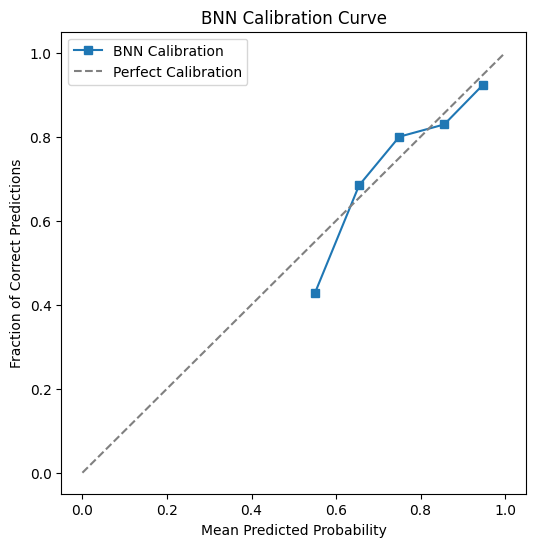

In [143]:
# run Monte Carlo -dropout and return average probabilities + true labels
def get_mc_dropout_predictions(model, dataloader, num_samples=100):
    # evaluation mode + enable dropout at inference (train())
    model.eval()
    model.train() 

    all_probs = []
    all_labels = []

    # no gradient updates
    with torch.no_grad():
        for inputs, labels in dataloader:
            batch_probs = []
            
            # run multiple "forward passes" -> monte carlo sampling
            for _ in range(num_samples): 
                outputs = model(inputs)  
                probs = torch.softmax(outputs, dim=1).cpu().numpy()  
                batch_probs.append(probs)

            # calculate mean probability
            avg_probs = np.mean(batch_probs, axis=0)
            all_probs.append(avg_probs)
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_probs), np.hstack(all_labels)

# helper function to actually plot the calibration curve
def plot_calibration_curve(model, dataloader, num_samples=100, bins=10):
    # see function above 
    probs, labels = get_mc_dropout_predictions(model, dataloader, num_samples)
    
    # take max probability and corresponding true class
    confidences = np.max(probs, axis=1)  
    predictions = np.argmax(probs, axis=1) 

    # correct predictions 
    correct = (predictions == labels).astype(int) 
    
    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(correct, confidences, n_bins=bins)
    
    # plot the calibration curve
    plt.figure(figsize=(6,6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="BNN Calibration")
    plt.plot([0,1], [0,1], "--", color="gray", label="Perfect Calibration")
    
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Correct Predictions")
    plt.title("BNN Calibration Curve")
    plt.legend()
    plt.show()

# use current model and test data to create a calibration curve, adjust samples if needed
# might be a good idea to use same amount of samples as in training (mc_samples)
plot_calibration_curve(model, test_loader, num_samples=100)

# calibration curve interpretation:

# perfect calibration = if the curve follows this line, the model is well calibrated
# OVERCONFIDENT => if the curve is BELOW the diagonal, the model assigns higher probabilities than it should
# UNDERCONFIDENT => if the curve is ABOVE the diagonal, the model undershoots it's probability estimations

# how to optimize:
# if overconfident => if categorical classification, try Temperature/Platt-scaling, 
# for other models, adjust hyperparameters, model structure etc.

# if underconfident: get more data or add more regularization

# IF THE LINE IS COMPLETELY MISALIGNED:
# increase MC samples to improve uncertainty estimation

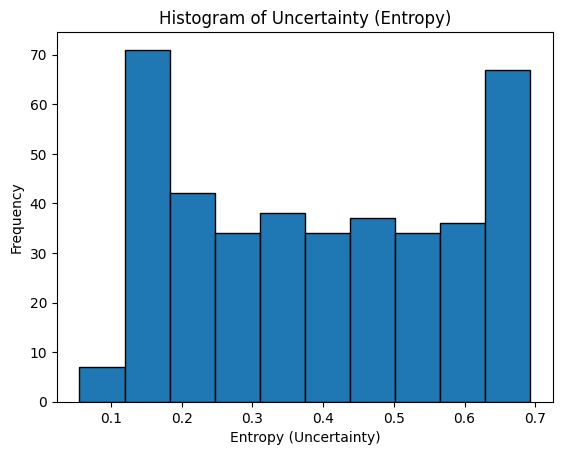

In [144]:
# convert to a numpy array for easier manipulation
y_pred_probs = np.array(y_pred_probs)

# calculate entropy for each sample (sum of -p * log(p) for each class)
entropy = -np.sum(y_pred_probs * np.log(y_pred_probs + 1e-10), axis=1)  # Add small epsilon to avoid log(0)

# plot histogram of entropy
plt.hist(entropy, bins=10, edgecolor='k')
plt.xlabel('Entropy (Uncertainty)')
plt.ylabel('Frequency')
plt.title('Histogram of Uncertainty (Entropy)')
plt.show()

# in optimal case, entropy is stacked on the left side
# with only a small number of uncertainty on the high end

# this particular example is a very bad result, most uncertainty
# is in the high end

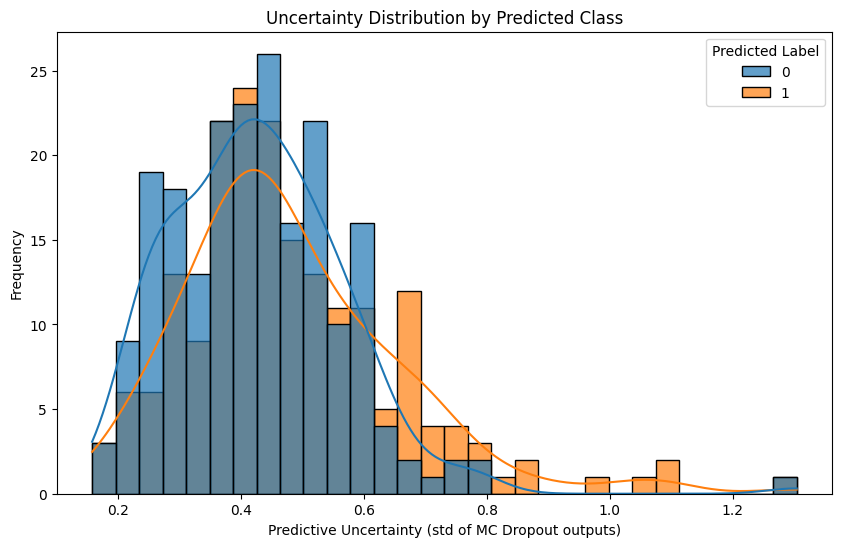

In [145]:
# store predictive uncertainties and predicted classes
uncertainties = []
predicted_classes = []

# perform inference and collect uncertainty metrics for each sample
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(10)]
        outputs_stack = torch.stack(outputs_list)  
        
        # compute mean and std (uncertainty) of predictions
        outputs_mean = outputs_stack.mean(dim=0)  
        outputs_std = outputs_stack.std(dim=0)  

        # convert to probabilities
        probs = torch.softmax(outputs_mean, dim=1).cpu().numpy()
        
        # compute uncertainty as standard deviation of probabilities
        uncertainty_per_sample = outputs_std.mean(dim=1).cpu().numpy()  # Averaged across classes
        
        # get predicted class
        preds = np.argmax(probs, axis=1)

        # store results
        uncertainties.extend(uncertainty_per_sample)
        predicted_classes.extend(preds)

# convert to pandas DataFrame for easier plotting
plot_df = pd.DataFrame({"Uncertainty": uncertainties, "Predicted Class": predicted_classes})

# Convert predicted class to categorical
# plot_df["Predicted Class"] = plot_df["Predicted Class"].astype(str)

# HOTFIX to get the labels in the plot df
plot_df['Predicted Label'] = plot_df['Predicted Class'].map(lambda x: categories[x])

# plot uncertainty distributions by class
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x="Uncertainty", hue="Predicted Label", bins=30, kde=True, palette="tab10", alpha=0.7, legend=True)
plt.xlabel("Predictive Uncertainty (std of MC Dropout outputs)")
plt.ylabel("Frequency")
plt.title("Uncertainty Distribution by Predicted Class")

# quick/dirty fix to avoid the bug with numeric labels for matplotlib
handles, labels = plt.gca().get_legend_handles_labels()
if labels: 
    # add prefix "Class" for each target label (which is a number), e.g. Class 3
    class_labels = [f"Class {l}" for l in labels]  
    plt.legend(handles, class_labels, title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

# might be a good idea to compare this result to confusion matrix to see if the categories match

# in this case, the model seems to be more uncertain with survived passengers

In [146]:
# you can adjust the mc_samples to improve uncertainty estimation, 
# values in the range 50-100 are usually ok, sometimes even more
def process_single_row_with_uncertainty(model, input_row, device, mc_samples=50):
    # set model to evaluation mode
    model.eval()  

    # convert input row to a tensor and reshape it to match model input
    input_tensor = torch.tensor(input_row, dtype=torch.float32).unsqueeze(0).to(device)  

    # disable gradient updates, since we are not training at the moment
    with torch.no_grad():  
        # perform multiple forward passes with dropout enabled
        outputs_list = [model(input_tensor, mc_dropout=True) for _ in range(mc_samples)]
        outputs_stack = torch.stack(outputs_list) 

        # compute mean prediction (expected class probabilities)
        outputs_mean = outputs_stack.mean(dim=0).squeeze()  

        # compute uncertainty (standard deviation of probabilities across MC samples)
        outputs_std = outputs_stack.std(dim=0).squeeze()

        # convert logits to probabilities using softmax
        pred_probs = torch.softmax(outputs_mean, dim=0).cpu().numpy()
        pred_uncertainty = outputs_std.cpu().numpy() 

        # predicted class is the one with the highest probability
        pred_class = np.argmax(pred_probs)

    return pred_class, pred_probs, pred_uncertainty


# text labels for the 6 different target categories
labels = categories

# add your support variable values here for a new row
tester_row = {
    "age": 54,
    "job": 0,
    "marital": 1,
    "education": 2,
    "default": 0,
    "balance": 184,
    "housing": 0,
    "loan": 0,
    "contact": 2,
    "day": 5,
    "month": 8,
    "duration": 673,
    "campaign": 2,
    "pdays": -1,
    "previous": 0,
    "poutcome": 3,
    # deposit — это целевая переменная, НЕ включаем если предсказываем
}


# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

# get values and scale with same scaler as original training data
input_row = tester_row.values[0]
input_row = scaler.transform([input_row])
input_row = list(input_row[0])

# run the model and get predictions, probabilities and uncertainties
pred_class, pred_probs, pred_uncertainty = process_single_row_with_uncertainty(model, input_row, torch.device('cpu'))

# set print options to suppress scientific notation
np.set_printoptions(suppress=True)

# see the results
print(f"Predicted Class: {pred_class}")
print(f"Predicted Probabilities: {pred_probs}")
print(f"Predictive Uncertainty (per class): {pred_uncertainty}")
print(f"Predicted Class name (original label): {labels[pred_class]}")


# uncertainty is not a percentage, the value can be anything 0 - 150, or even more

Predicted Class: 1
Predicted Probabilities: [0.38009182 0.61990815]
Predictive Uncertainty (per class): [0.14933775 0.14559932]
Predicted Class name (original label): 1
